In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

# Part 1: Outcomes from No-regret Learning in Games

## Set Up and Algorithm Definition

In [3]:
class EWAlg:
    def __init__(self, epsilon, k, h, myBids, myValue):
        self.weights = np.ones(k)
        self.payoffs = np.zeros(k)
        self.h = h
        self.k = k
        self.epsilon = epsilon
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myValue = myValue
        self.myBids = myBids
        self.myTotalValue = 0

    def getBids(self):
        return self.myBids

    def getValue(self):
        return self.myValue

    def getTotalValue(self):
        return self.myTotalValue

    def getAction(self):
        j = np.random.choice(self.k, 1, p = self.probs)
        return self.myBids[j.item()]
    
    def update(self, payoffs):
        for j in range(len(payoffs)):
            curPayoff = payoffs[j]
            self.payoffs[j] = self.payoffs[j] + curPayoff
            newWeight = (1+self.epsilon)**(self.payoffs[j]/self.h)
            self.weights[j] = newWeight
        self.sumWeights = np.sum(self.weights)
        if(self.epsilon > 1):
            self.weights = self.weights/self.sumWeights
            self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        return

    def generatePayoffs(self, bidToBeat, winningBid, meWin):
        if meWin:
            self.myTotalValue += self.myValue - winningBid
        payoffs = np.zeros(self.k)
        for count, bid in enumerate(self.myBids):
            if bid >= bidToBeat:
                payoffs[count] = self.myValue - bid
            else:
                payoffs[count] = 0
        return payoffs
    
    def reset(self):
        self.weights = np.ones(self.k)
        self.payoffs = np.zeros(self.k)
        self.sumWeights = np.sum(self.weights)
        self.probs = self.weights/self.sumWeights
        self.myTotalValue = 0


In [40]:
class FirstPriceReserve:
    # bidders have to be ordered the same way every time
    # reserve given as a raw value
    def __init__(self, numBidders, reserve = 0):
        self.numBidders = numBidders
        self.totalPayoffs = np.zeros(self.numBidders)
        self.reserve = reserve
        
    def generate(self, bids):
        winningBid = 0
        winner = -1
        tiedBidders = []
        tied = False
        generatedBids = bids
        generatedBids.append(self.reserve)
        # check bids of all bidders
        for count, bid in enumerate(bids):
            if bid > winningBid:
                winningBid = bid
                winner = count
            elif (bid == winningBid) and (winner != -1):
                tiedBidders.append(count)
                tied = True
        if tied : winner = random.choice(tiedBidders)
        # see if winning bid is greater than reserve price
        if (winningBid < self.reserve): 
            winningBid = self.reserve
            winner = -1
        return [generatedBids, winningBid, winner]

In [41]:
numPlayers = 2
n = 500
# epsilons = [0.0774,0.0774]
epsilons = [0.1, 0.1]
h = 10
min = 1
k = 50
stepSize = np.log(h) / k

def setUpPlayers() :
    # set up our players
    players = []
    for count in range(numPlayers):
    # pick a distribution and numPlayers values from it
        playerValue = random.uniform(min,h)
        # create possible bids using geometric discretization
        playerBids = []
        for j in range(k):
            playerBids.append(playerValue - ((1 + stepSize)**(-j))*playerValue)
        # create player
        player = EWAlg(epsilons[count], k, h, playerBids, playerValue)
        players.append(player)
    return players

def conductAuction(players, auction, n = 100):
    # print("WE ARE IN conductAuction")
    # do the action n times
    allBidsCA = []
    allWinners = []
    for i in range(n):
        # print("round", i)
        bids = []
        # generate bids
        for count, player in enumerate(players):
            bids.append(player.getAction())
        # print("the bids are", bids)
        currbids = bids.copy()
        allBidsCA.append(bids)
        # print("allBidsCA is now", allBidsCA)
        
        # conduct auction
        # print("running auction.generate")
        # roundBids, winningBid, winner = auction.generate(bids)
        results = auction.generate(currbids) #<-- somehow an extra 0 is getting added to the list
        roundBids = results[0]
        winningBid = results[1]
        winner = results[2]
        allWinners.append(winner)
        # print("allWinners is now", allWinners)
        # update payoffs
        
        for count, player in enumerate(players):
            oppositionBids = roundBids.copy()[:2]
            # print("we are on player {}".format(count))
            # print("our bid is {}".format(oppositionBids[count]))
            # print("the opposition bids are ", oppositionBids)
            oppositionBids[count] = 0
            bidToBeat = max(oppositionBids)
            # print("this is the bid to beat: ", bidToBeat)
            if count == winner:
                # print("we are the winner!")
                payoffs = player.generatePayoffs(bidToBeat, winningBid, True)
            else:
                # print("we are not the winner :(")
                payoffs = player.generatePayoffs(bidToBeat, winningBid, False)
            player.update(payoffs)
            #print(payoffs)
        # print("allBidsCA is now ", allBidsCA)
        # print("appending bids to allBidsCA now")
        # print("the bids are", bids)
        
        # print("at the end of the round, allBidsCA is now", allBidsCA)
    # print("final allBids is ", allBidsCA)
    return allBidsCA, allWinners

In [42]:
# playerBids = []
# playerValue = random.uniform(min,h)
# stepSize = np.log(h) / k
# print(playerValue)
# print(stepSize)
# for j in range(k):
#     playerBids.append(playerValue - ((1 + stepSize)**(-j))*playerValue)
# print(playerBids)

In [43]:
MCBound = 100
n = 1000
reserveFrac = 0 #between 0 and 1
reserveValue = reserveFrac * h
# set up players
players = setUpPlayers()
# set up the auction 
auction = FirstPriceReserve(2, reserveValue)

values = []
totalWinnings = [[], []]
possibleBids = []
for player in players:
    values.append(player.getValue())
    possibleBids.append(player.getBids())

MCBids = []
MCWinners = []
for i in range(MCBound):
    # conduct auction
    allBids, allWinners = conductAuction(players, auction, n)
    # print("all bids = ", allBids)
    for count, player in enumerate(players):
        totalWinnings[count].append(player.getTotalValue())
    # reset players -> they keep same learning rate and values
    for player in players:
        player.reset()
    MCBids.append(allBids)
    MCWinners.append(allWinners)
avgBids = np.array(MCBids)
avgBids = np.mean(avgBids, 0)
totalWinnings = np.mean(np.array(totalWinnings), 1)

# print(values)
# print(totalWinnings)
# print(MCWinners)
# print(MCBids)

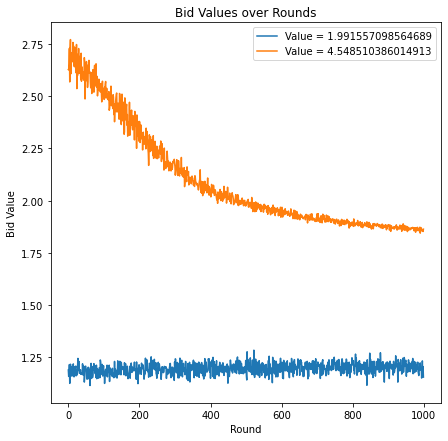

In [ ]:
f = plt.figure()
f.set_figwidth(7)
f.set_figheight(7)

newBids = [[], []]
for i in range(n):
    newBids[0].append(avgBids[i][0])
    newBids[1].append(avgBids[i][1])

plt.plot(np.arange(n), newBids[0], label = "Value = " + str(values[0]))
plt.plot(np.arange(n), newBids[1], label = "Value = " + str(values[1]))
plt.title('Bid Values over Rounds')
plt.xlabel('Round')
plt.ylabel('Bid Value')
plt.legend()
plt.show()
# f.savefig('RegretvRoundAf.png')

In [9]:
def MonteCarlo(numTrials, payoffGenerator, epsilon, k, h, n):
    avgFinalPayoff = 0
    avgRegretPerRound = [[] for i in range(numTrials)]
    for trial in range(numTrials):
        alg = EWAlg(epsilon, k, h)
        finalPayoff = 0
        actionPayoffs = np.zeros(k)
        generator = payoffGenerator(k)
        regretPerRound = np.zeros(n)
        for i in range(n):
            payoffs = generator.generate()
            j = alg.getAction()
            myPayoff = payoffs[j]
            actionPayoffs += payoffs
            alg.update(payoffs)
            finalPayoff += myPayoff
            OPT = max(actionPayoffs)
            regret = (OPT - finalPayoff).item() / (i+1)
            regretPerRound[i] = regret
        avgFinalPayoff += finalPayoff
        avgRegretPerRound[trial] = regretPerRound
    return avgFinalPayoff/numTrials, np.mean(avgRegretPerRound, axis=0)

In [10]:
def MonteCarloTrackActions(numTrials, payoffGenerator, epsilon, k, h, n):
    avgFinalPayoff = 0
    avgRegretPerRound = [[] for i in range(numTrials)]
    actionTrial = []
    for trial in range(numTrials):
        alg = EWAlg(epsilon, k, h)
        finalPayoff = 0
        actionPayoffs = np.zeros(k)
        generator = payoffGenerator(k)
        regretPerRound = np.zeros(n)
        actions = np.zeros(n)
        for i in range(n):
            payoffs = generator.generate()
            j = alg.getAction()
            actions[i] = j
            myPayoff = payoffs[j]
            actionPayoffs += payoffs
            alg.update(payoffs)
            finalPayoff += myPayoff
            OPT = max(actionPayoffs)
            regret = (OPT - finalPayoff).item() / (i+1)
            regretPerRound[i] = regret
        actionTrial.append(actions)
        avgFinalPayoff += finalPayoff
        avgRegretPerRound[trial] = regretPerRound
    return avgFinalPayoff/numTrials, np.mean(avgRegretPerRound, axis=0), np.array(actionTrial)

## Adversarial Fair Payoffs

In each round i:

Draw a payoff x ~ U[0,1] (i.e., from the uniform distribution on interval [0,1])

Assign this payoff to the action j* that has the smallest total payoff so far, i.e., j* = argminj Vji-1 where Vji = Σir=1 vji. 
(All other actions get 0 payoff in round i.)

In [10]:
h = 1 # fixed
# hyperparameters
k = 10
n = 100
epsilons = [-0.99, -0.5, 0, 0.1, 0.1517, 0.2, 0.4, 0.7, 1, 2, 10, 1000] # to be studied
monteCarloBound = 1000

AFEpsilonPayoffs = []
AFEpsilonRegretPerRound = []
for epsilon in epsilons:
    finalPayoff, regretPerRound = MonteCarlo(monteCarloBound, AdversarialFair, epsilon, k, h, n)
    AFEpsilonPayoffs.append(finalPayoff)
    AFEpsilonRegretPerRound.append(regretPerRound)

AFEpsilonAvgRegrets = [i[99] for i in AFEpsilonRegretPerRound]
print(epsilons)
print(AFEpsilonPayoffs)
print(AFEpsilonAvgRegrets)

NameError: name 'AdversarialFair' is not defined